<a href="https://colab.research.google.com/github/kristina0614/Computer-Vision-Course/blob/main/MNIST_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 1:

* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits). 
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images. 
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
* We also perform similar experiments comparing the values at two pixel locations in the images with the class labels. This time we use `scatter plots` to visualize the relationship between the pair of pixel values with the class labels (represented by different colored dots).
* Pixel values at two locations in image should not have much predictive value. To improve on this approach, we the PCA decomposition on both the raw data of 784 pixel values and 128 hidden node activation values to reduce the number of features to 2 in each case. Once again, we use a `scatter plot` to visualize the correlation between the two principal component values and the class labels.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

## 1. Importing Packages 

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [ ]:
# Helper libraries
import datetime
from packaging import version
import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
#from plot_keras_history import plot_history

In [ ]:
#when plot, plot inside the notebook

%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

### Verify TensorFlow version and Keras version

In [ ]:
#make sure using the code that works in V2 (version 1 does not work in version 2 all the time)
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.5.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.5.0


### Mount Google Drive to Colab environment

In [ ]:
#saves what I create to my google drive
#also allows me to pull data down from my google drive, if necessary
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [ ]:
#MNIST dataset is part of keras library and knows how load and split data in the tool itself
#this data set split is randomized
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

## 3. EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [ ]:
#not as much EDA required with this data set

print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


### Review labels for training set

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



### Find frequency of each label in training and test sets

In [ ]:
#this is one of the most important steps in ML
#what is the spread of the data
Counter(y_train).most_common()

#this data is well distributed

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [ ]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

### Plot sample images with their labels

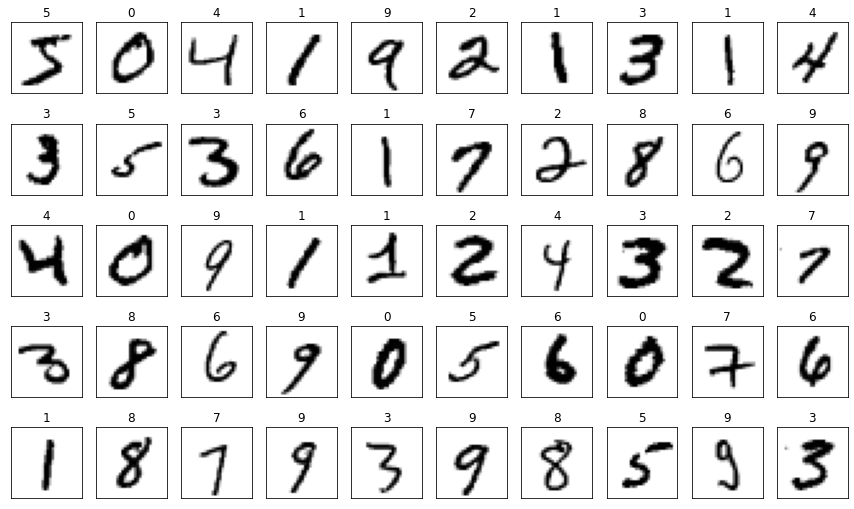

In [ ]:
fig = plt.figure(figsize = (15, 9))

#shows the first 50 images
for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

## 4. Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s. 
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

### Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [ ]:
#we are one hot encoding but this is not required as we do not have any missing 
#the data set has been currated for us
#this will respresent the labels in binary type format
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


### Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [ ]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [ ]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [ ]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

### Review unique values with set from 1st image

In [ ]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


### Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [ ]:
#gray scale only has one channel coming in 
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [ ]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}


### **Create PCA using 95% or 154 features**

In [ ]:
# Make an instance of the Model
pca = PCA(.95)

In [ ]:
#since we used one hot encoding, we do not have to scale the data
#as it is already in 0s and 1s

pca.fit(x_train_norm)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
x_train_norm = pca.transform(x_train_norm)
x_test_norm = pca.transform(x_test_norm)

## 5. Creating the DNN Model

* In this step, we first choose the network architecture for the model. Then we build.compile, train and evaulate the model.

### Specify the network architecture

Below is the neural network architecture we will use today for classifying MNIST digits.

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/DNN_architecture.png?raw=1">

### Build the DNN model

We use a `Sequential` class defined in `Keras` to create our model. All the layers are going to be Dense layers. This means, like the figure shown above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

After the model is built, we view ....

In [ ]:
#functionaly or sequential available
#sequential stack like pancakes, with each layer understanding that input is
#output from the previous layer
#functional models give a lot more granulirity (behaves the same way) but
#need to specify the ouput and input for each layer

#units is the hidden layer parameters
#units and hidden nodes are interchangeable
model = Sequential([
    Dense(input_shape=[154,], units = 154, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
#this model is not very big
#this one only have 100k weights to be calculated
#when increase to M or Bs then take longer
#parameters is another way to say weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 154)               23870     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1550      
Total params: 25,420
Trainable params: 25,420
Non-trainable params: 0
_________________________________________________________________


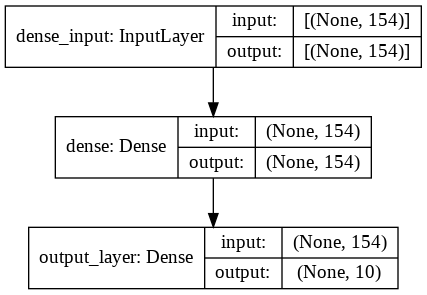

In [ ]:
#this gives us a visualization of our model object to see how the model is working
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compile the DNN model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimized in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimizes the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.


<b>tf.keras.optimizers.RMSprop</b><br> 
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop


<b>tf.keras.losses.CategoricalCrossentropy</b><br> 
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


In [ ]:
#compiling is where we add the optimizer
#how much the model adjusts paramaters in each epoch
#how wrong we are
#measyring accuracy
model.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

### Train the DNN model

<b>tf.keras.model.fit</b><br>
  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
#he likes using 200 epochs but we can make it whatever
#validation step is saying take 20% of the data set and make that the validation data 
history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20 
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )
#early stopping says to stop training the model after a certain point in time until it stops getting a certain accuracy improvement
#will stop if validation accuracy stops improving to prevent overfitting
#the early stopping helps to prevent overfitting and makes the epochs less important
#play around with what you use to monitor (can monitor loss as well) to find the best way to manage the processing

Epoch 1/200
1500/1500 [==============================] - 3s 1ms/step - loss: 0.3207 - accuracy: 0.9130 - val_loss: 0.1555 - val_accuracy: 0.9566
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1238 - accuracy: 0.9646 - val_loss: 0.1125 - val_accuracy: 0.9671
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0820 - accuracy: 0.9764 - val_loss: 0.0971 - val_accuracy: 0.9720
Epoch 4/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0578 - accuracy: 0.9841 - val_loss: 0.0889 - val_accuracy: 0.9748
Epoch 5/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0425 - accuracy: 0.9881 - val_loss: 0.0898 - val_accuracy: 0.9756
Epoch 6/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0318 - accuracy: 0.9919 - val_loss: 0.0872 - val_accuracy: 0.9758
Epoch 7/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0239 - accuracy: 0.9941 - val_loss: 0.0897 - val_ac

### Evaluate the DNN model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 1ms/step - loss: 0.0793 - accuracy: 0.9774
test set accuracy:  97.7400004863739


## 6. Making Predictions

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


Look at the first 25 - Plot test set images along with their predicted and actual labels to understand how the trained model actually performed

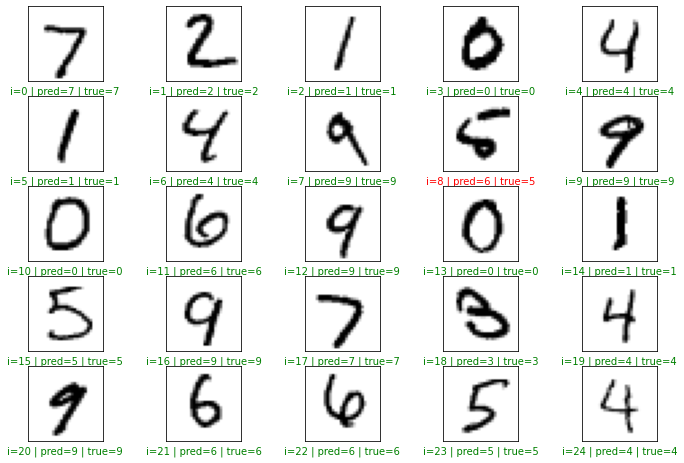

In [ ]:
plt.figure(figsize = (12, 8))

#play around where the model starts to test different scenarios
start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

#red means that the label and the prediction didn't match

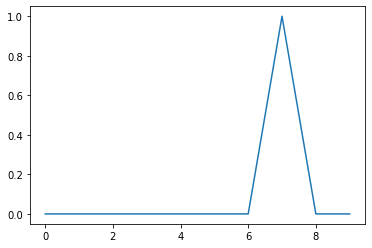

In [ ]:
#this tells us the output prediction layer for a particular index

"""
Enter the index value in place of the value 17 below for the prediction
that you want to plot the probability scores for
"""
index = 17

plt.plot(preds[index])
plt.show()

## 7. Reviewing Performance

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plot performance metrics 

We use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

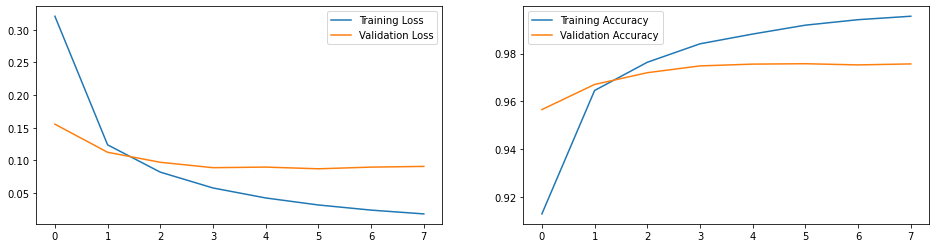

In [ ]:
#used keys to create a data frame and then plotted it out
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Create the confusion matrix

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes

array([7, 2, 1, ..., 4, 5, 6])

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
#visulizing confusion matrix helps see in classes that are close to eachother
#shows where models are running into issues

####save this code as will help with other research projects (F1 scores are 
####another gem to use)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%
1,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2,0.00%,99.96%,0.01%,0.00%,0.00%,0.00%,0.00%,0.02%,0.01%,0.00%
3,99.99%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,0.00%,0.00%,0.00%,0.00%,99.99%,0.00%,0.00%,0.00%,0.00%,0.01%
5,0.00%,99.98%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.00%,0.00%
6,0.00%,0.00%,0.00%,0.00%,99.96%,0.00%,0.00%,0.00%,0.03%,0.00%
7,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%
8,0.00%,0.00%,0.00%,0.00%,0.00%,25.46%,74.53%,0.00%,0.00%,0.00%
9,0.00%,0.00%,0.00%,0.00%,0.03%,0.00%,0.00%,0.00%,0.00%,99.97%


### Visualize the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Note that the rows represent actual classes while the columns represent predicted classes.

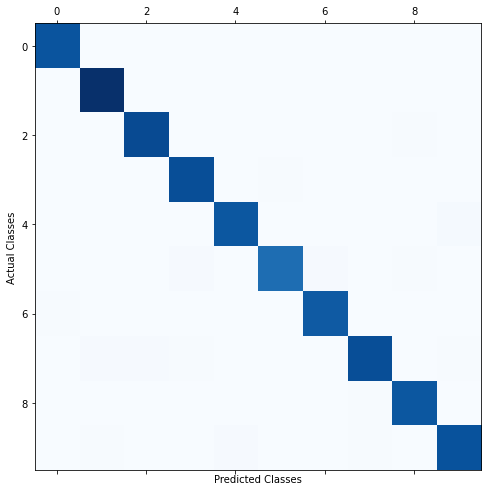

In [ ]:
#F1 score is another place that will be a value add
#if have a lower accuracy score, there will be a bigger shading difference

####this code will be helpful to use in the future

plt.figure(figsize=(16,8))
plt.matshow(conf_mx, cmap=plt.cm.Blues,  fignum=1)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

The confusion matrix looks quite good!

Looks like 28 fours were misclassified as nines (and 10 nines were classifed fours). We display some of these misclassfications along with exam of fours and nines that were correctly identified.

In [ ]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

ValueError: ignored

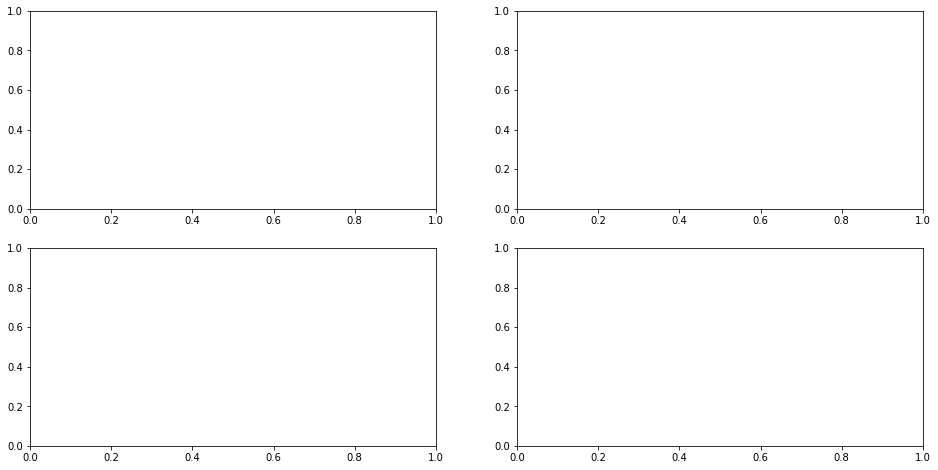

In [ ]:
#this lets you compare classes to see when things are improply categorized


cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

## 8. Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these *128 activations* as the features that determine the classification class. For the sake of comparison,  we also consider the *784 pixels* of each training image and determine the contribution of the individual pixels to the predicted classification class. 

Our goal is to use *box* and *scatter* plots to visualize how these features (*pixel* and *activation* values) correlate with the class labels. Because of the high dimension of the feature spaces, we apply *PCA decomposition* and *t-Distributed stochastic neighbor embedding* (`t-SNE`) to reduce the number of features in each case. 

We use the following two articles as reference

 * https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
 * https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


1) Raw data is 60,000 X 784. Just do a scatter plot of col 1 vs col 2. Overlay the color coded classes. We  should not see any patterns since there is not much info in 2 cols to discriminate.

2) PCA of raw data – as we discussed earlier. Plot PC1 vs PC2 with overlay. This should be ‘better’ since these 2 capture the info from all 784 cols.

3) PCA of activation values – as we discussed earlier. This should be ‘better’ than the previous 2 since it has captured specific features of discrimination.

 ### Get the activation values of the hidden nodes
 
To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 154)

In [ ]:
output_layer_activations.shape

(60000, 10)

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 9.081981658935547


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.    0.    0.    0.002 0.    0.998 0.    0.    0.    0.   ]
The sum of the probabilities is (approximately) 1.0


 ### Create a dataframe with the activation values and the class labels

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,128): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.000
act_val_0,0.500,0.000,0.000,0.739,0.000,0.000,2.499,0.531,2.109,3.041,2.558,1.971,0.223,0.156,2.462
act_val_1,0.000,0.532,0.849,0.000,0.778,0.000,0.000,0.545,0.000,1.185,1.699,0.000,0.000,0.571,0.000
act_val_2,1.321,0.000,0.000,1.808,0.000,0.000,2.259,0.000,1.324,0.000,0.000,0.000,0.000,0.000,2.095
act_val_3,0.513,1.612,4.073,0.000,0.000,3.218,0.000,3.659,0.000,3.230,0.000,0.693,0.000,1.108,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_123,0.000,2.557,0.000,0.000,0.197,2.433,0.000,0.000,0.000,1.452,0.000,1.022,0.000,0.985,0.000
act_val_124,0.000,1.177,2.078,0.000,0.192,0.000,0.000,0.249,0.000,0.000,0.365,0.526,0.341,0.000,0.000
act_val_125,0.260,1.865,0.000,0.485,0.000,0.000,0.000,0.000,0.153,0.117,0.347,0.000,0.000,0.000,0.000
act_val_126,0.565,0.000,0.715,0.000,0.640,0.000,2.258,0.000,1.055,1.267,0.000,0.066,0.000,1.260,0.000


 ### Visualize the activation values with boxplots
 
We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe. 

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

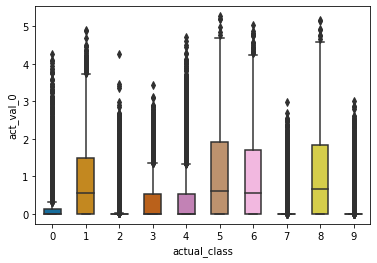

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

In [ ]:
# displaying the range of activation values for each class labels
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 4.27]"
1,1,"[0.0, 4.89]"
2,2,"[0.0, 4.26]"
3,3,"[0.0, 3.44]"
4,4,"[0.0, 4.7]"
5,5,"[0.0, 5.26]"
6,6,"[0.0, 5.03]"
7,7,"[0.0, 2.99]"
8,8,"[0.0, 5.17]"
9,9,"[0.0, 3.02]"


 ### Create a dataframe with the pixel values and class labels

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,128): 
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.000
pix_val_0,0.486,3.967,-0.203,-3.134,-1.501,0.723,-2.849,2.013,-3.408,-1.195,-0.573,-2.407,1.098,0.941,-3.389
pix_val_1,-1.226,-1.156,1.538,-2.381,2.865,0.868,-0.616,-1.219,-0.320,1.826,-2.523,-0.954,-3.258,0.591,-0.901
pix_val_2,-0.096,2.339,-0.739,1.073,0.064,2.319,-0.973,-0.408,-0.523,2.715,-0.986,1.353,-4.340,2.527,-0.387
pix_val_3,-2.179,-1.807,2.043,0.415,-0.948,0.204,0.284,-3.460,0.298,0.362,-2.777,1.759,-1.107,2.189,0.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_123,0.219,0.164,0.127,0.034,-0.334,0.081,-0.022,-0.050,0.035,-0.163,-0.075,0.597,0.186,0.208,-0.294
pix_val_124,-0.130,0.177,-0.245,-0.049,-0.173,0.129,0.043,0.326,0.059,-0.181,-0.032,-0.357,-0.138,0.184,0.020
pix_val_125,0.166,0.007,-0.012,0.076,-0.121,0.104,0.146,-0.004,0.000,0.063,-0.024,-0.017,-0.074,0.094,0.084
pix_val_126,-0.254,0.084,0.078,0.025,-0.075,0.109,-0.137,0.091,0.014,0.090,0.090,-0.208,-0.056,0.165,0.129


In [ ]:
pixel_df.pix_val_77.value_counts()

 0.146110    2
 0.103873    2
-0.281963    2
-0.434914    2
-0.163124    2
            ..
-0.239399    1
 0.088449    1
-0.119699    1
 0.059849    1
-0.437501    1
Name: pix_val_77, Length: 59972, dtype: int64

In [ ]:
pixel_df.pix_val_78.value_counts()

-0.261870    2
 0.034609    2
 0.479454    2
-0.006565    2
-0.322271    2
            ..
-0.165830    1
-0.208078    1
-0.331084    1
-0.239327    1
 0.375001    1
Name: pix_val_78, Length: 59976, dtype: int64

### Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

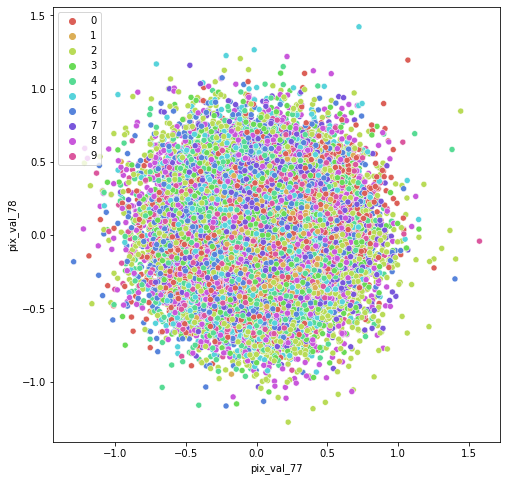

In [ ]:
plt.figure(figsize=(8, 8))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 9. PCA Feature Reduction / Model Optimization 

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

### Use PCA decomposition to reduce the number of features from 784 features to 2 features 

In [ ]:
# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

#picked the top two components in the model for PCA (first 2 columns)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)

In [ ]:
pixel_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,0.486,-1.226,5
1,3.967,-1.156,0
2,-0.203,1.538,4
3,-3.134,-2.381,1
4,-1.501,2.865,9


In [ ]:
#helps explain a large portion of the variance in the model
#this enables us to explain the model with just a little of the features
pca.explained_variance_ratio_

array([0.104, 0.076], dtype=float32)

### Use a scatter plot to visualize the predictive power of the two principal component values.

Using seaborn this time...

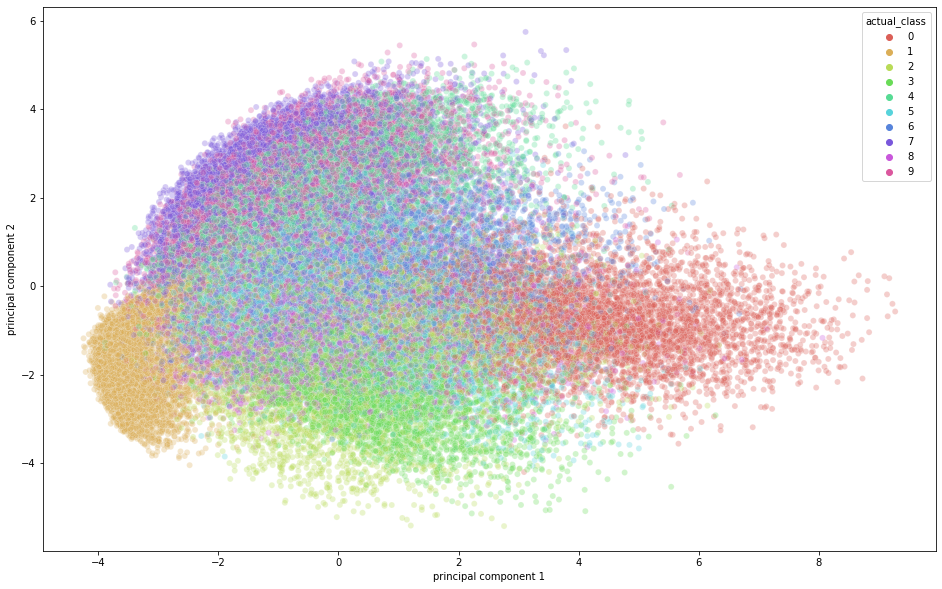

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
);

### Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 2

In [ ]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head().round(3)

,principal component 1,principal component 2
0,-3.230,0.739
1,2.886,4.139
2,3.926,-1.501
3,-3.286,-0.407
4,0.751,-3.816


In [ ]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,-3.230,0.739,5
1,2.886,4.139,0
2,3.926,-1.501,4
3,-3.286,-0.407,1
4,0.751,-3.816,9


In [ ]:
pca.explained_variance_ratio_

array([0.097, 0.079], dtype=float32)

The 2 principal components summed together 0.169 + 0.105 = .274 explained variance 

### Use a scatter plot to visualize the predictive power of *two* principal component values.

Using seaborn this time

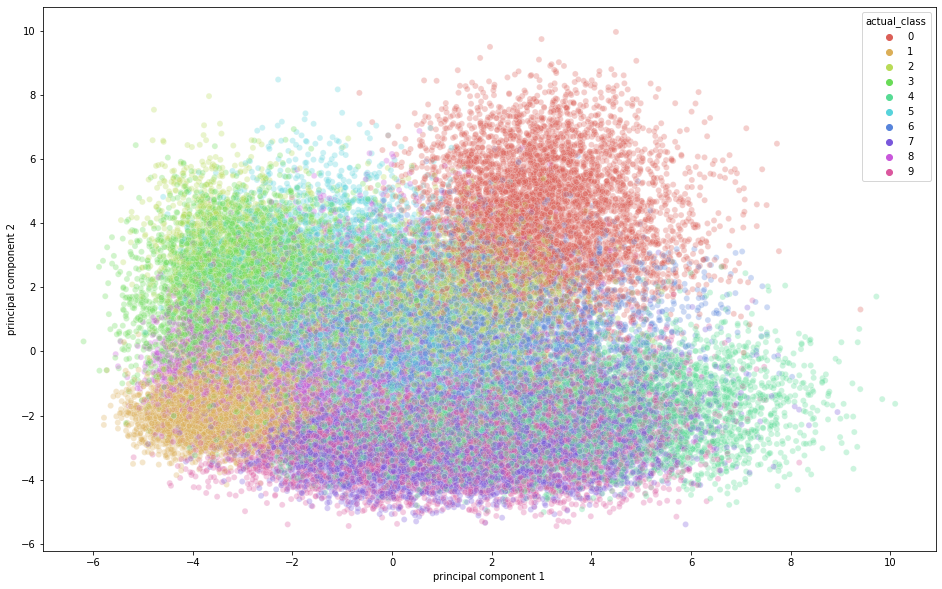

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=activation_pca_df,
    legend="full",
    alpha=0.3
);

### Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 3

In [ ]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head(10).round(3).T

,0,1,2,3,4,5,6,7,8,9
pca-one,-3.230,2.886,3.926,-3.286,0.751,1.186,-4.104,-2.267,-2.798,2.559
pca-two,0.739,4.139,-1.501,-0.407,-3.816,0.356,-1.527,0.913,-1.633,-2.396
pca-three,-1.261,2.963,0.339,1.596,-1.662,1.575,0.434,-2.393,0.800,4.552


In [ ]:
pca.explained_variance_ratio_

array([0.097, 0.079, 0.075], dtype=float32)

The 3 principal components summed together 0.169 + 0.105 + 0.099 = 0.373 explained variance 

In [ ]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,pca-one,pca-two,pca-three,actual_class
0,-3.230,0.739,-1.261,5
1,2.886,4.139,2.963,0
2,3.926,-1.501,0.339,4
3,-3.286,-0.407,1.596,1
4,0.751,-3.816,-1.662,9


### Use a scatter plot to visualize the predictive power of *three* principal component values

In [ ]:
#uncomment to to able to rotate the graph...
#can take 15 minutes to render the graph
%matplotlib notebook   
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=activation_pca_df.loc[:,"pca-one"], 
    ys=activation_pca_df.loc[:,"pca-two"], 
    zs=activation_pca_df.loc[:,"pca-three"], 
    c=activation_pca_df.loc[:,"actual_class"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Use t-Distributed Stochastic Neighbor Embedding (**t-SNE**)  to reduce the (activation) features from 128 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.

See http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
activation_df.shape

(60000, 129)

In [ ]:
N=60000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(60000, 129)

In [ ]:
data_subset = activation_df_subset[features].values
data_subset.shape

(60000, 128)

In [ ]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 4.769s...
[t-SNE] Computed neighbors for 60000 samples in 1216.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for

In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

In [ ]:
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
# plt.figure(figsize=(10, 8))
#using the TSNE approach clusters the data together quite well
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_train, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10. Reducing dimensionality of the data with Random Forests.

We create a Random Forest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features (using code from Hands On Machine Learning by A. Geron). Finally, we select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
#shows which pixels, regardless of the image have the most predictive power
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

ValueError: ignored

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
#give us the 70 parameters that have the most power
#helps to reduce data by 90%
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

In [ ]:
# Create training and test images using just the 70 pixel locations obtained above
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

### Visualize the 70 pixels
We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

In [ ]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

In [ ]:
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)